In [4]:
import numpy as np
import matplotlib.pyplot as plt
#!pip install scipy
from scipy import stats
from scipy import optimize

# Learning in Repeated Advertising Auctions

## Click Visualization Model

### Important Quantities
### Given an ad $a$ and a slot $s$, each time $t$ a user arrives:
- ### $\lambda_s$: probability that the slot $s$ is observed by the user (slot prominence)
- ### $q_a$: probability that the ad is clicked ***given that the user has seen it*** (ad quality)
- ### $v_a$: ad's profit per click (ad value)

### If ad $a$ is placed in slot $s$, the advertiser gets expected utility $\lambda_s q_a v_a$

### Assumptions of this model:
- ### All the quantities are **fixed** and don't vary with time.
- ### Ad's quality $q_a$ and profit-per-click $v_a$ don't depend on the slot.
- ### Prominence $\lambda_s$ doesn't depend on the ad.

In [5]:
class Auction:
    def __init__(self, *args, **kwargs):
        pass

    def get_winners(self, bids):
        pass

    def get_payments_per_click(self, winners, values, bids):
        pass

    def round(self, bids):
        winners, values = self.get_winners(bids) # allocation mechanism!
        payments_per_click = self.get_payments_per_click(winners, values, bids)
        return winners, payments_per_click


# Non-Truthful Auctions

#### In non-truthful auctions, we additionally assume that the **bids are discretized in a finite set**.

## Publisher's Perspective

### Single Slot

In [ ]:
class FirstPriceAuction(Auction):
    def __init__(self, ctrs):
        self.ctrs = ctrs
        self.n_adv = len(self.ctrs)
    
    def get_winners(self, bids):
        adv_values = self.ctrs*bids
        adv_ranking = np.argsort(adv_values)
        winner = adv_ranking[-1]
        return winner, adv_values
    
    def get_payments_per_click(self, winners, values, bids):
        payment = bids[winners]
        return payment

In [7]:
# advertisers' fixed parameters
n_adv = 4 # four advertisers
ctrs = np.array([0.8, 0.65, 0.50, 0.75])
v = np.array([0.7, 1.1, 1.4, 0.85])

# environmental settings
n_users= 3

auction = FirstPriceAuction(ctrs=ctrs)
for u in range(n_users):
    print(f'# User {u}')
    bids = np.random.choice([0.25, 0.5, 0.75, 1], size=n_adv)
    pub_values = bids*ctrs
    print(f'Bids: {bids}, Publisher Values: {pub_values}')
    winner, payment_per_click = auction.round(bids=bids)
    print(f'Auction Winner: {winner}, Payment-per-click: {payment_per_click}')
    print(f'Payment == Bid : {payment_per_click == bids[winner]}')


# User 0
Bids: [0.25 0.5  0.5  0.25], Publisher Values: [0.2    0.325  0.25   0.1875]
Auction Winner: 1, Payment-per-click: 0.5
Payment == Bid : True
# User 1
Bids: [1.  0.5 1.  0.5], Publisher Values: [0.8   0.325 0.5   0.375]
Auction Winner: 0, Payment-per-click: 1.0
Payment == Bid : True
# User 2
Bids: [0.25 0.25 0.5  0.25], Publisher Values: [0.2    0.1625 0.25   0.1875]
Auction Winner: 2, Payment-per-click: 0.5
Payment == Bid : True


## Advertiser's Perspective: learning in repeated first price auctions

## Baseline

### We assume from now on that all CTRs are equal to 1
### Stochatic setting

C:\Users\matteo\AppData\Local\Temp\ipykernel_3244\2044859251.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


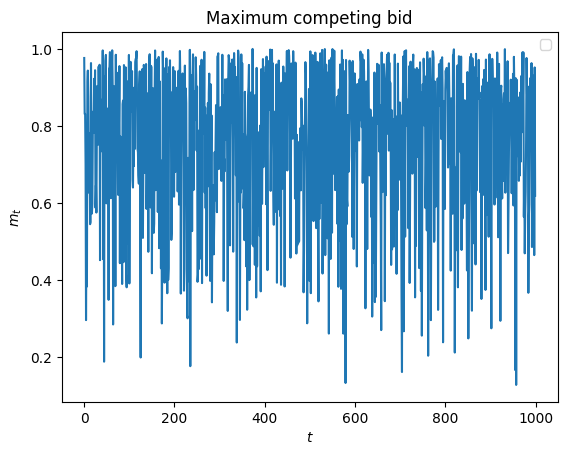

In [8]:
### Stochastic Bidders: my competitors sample their bids from 
### probability distributions

n_advertisers = 3
n_users = 1000
B = 150
my_valuation = 0.6
rho = B/n_users

# simple scenario: competitors sample bids from a uniform 
other_bids = np.random.uniform(0, 1, size = (n_advertisers, n_users))
# I assume that competitors may have a larger budget than mine, but they may
# not deplete it.
m_t = other_bids.max(axis=0)

plt.title("Maximum competing bid")
plt.plot(m_t)
plt.xlabel('$t$')
plt.ylabel('$m_t$')
plt.legend()
plt.show()

#### We are in a **stochastic** environment, thus we can use a notion of clairvoyant in **expectation**, i.e., the clairvoyant doesn't know all the actual bids but their distributions only. This clairvoyant is weaker than the one presented for truthful auctions. However, it is allowed to exceed budget (it only satisfies the budget constraint in expectation).

#### This is our optimization problem for the stochastic setting:
$$ \text{maximize}_{\gamma \in \Delta(B)}~~~ \sum_b \gamma(b)(v - b)\mathbb{P}_m(b \ge m) ~~~ \text{s.t.} \sum_b b \gamma(b) \mathbb{P}_m(b \ge m) \le \rho,$$
#### where $\gamma(b)$ is the probability of bidding $b$. This is a Linear Program! (LP)

#### When the competing bids are $b_i \sim U([0,1]), i=1,\dots,k$, 
#### the maximum is $m_t \sim Beta(k,1)$.

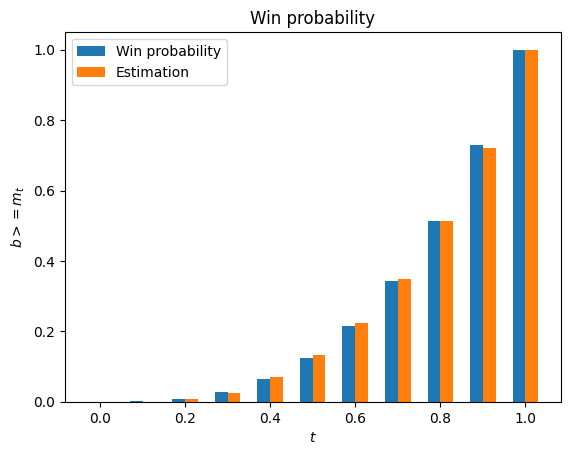

In [9]:
### the maximum among k uniformly distributed r.v.s is a beta r.v. with alpha=k and beta=1
available_bids = np.linspace(0,1,11)
win_probabilities = stats.beta.cdf(available_bids, n_advertisers, 1)

emp_win_probabilities = np.array([np.sum(b >= m_t) for b in available_bids])/len(m_t)

plt.title("Win probability")
width = 0.03
plt.bar(available_bids -width/2, win_probabilities, width=width, align='center', label='Win probability')
plt.bar(available_bids +width/2, emp_win_probabilities, width=width, align='center', label='Estimation')
plt.xlabel('$t$')
plt.ylabel('$b >= m_t$')
plt.legend()
plt.show()

In [10]:
## Linear Program
def compute_clairvoyant(available_bids, my_valuation, rho, win_probabilities):
    c = -(my_valuation-available_bids)*win_probabilities
    A_ub = [available_bids*win_probabilities]
    b_ub = [rho]
    A_eq = [np.ones(len(available_bids))]
    b_eq = [1]
    res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(0,1))
    gamma = res.x
    
    return gamma, -res.fun, np.sum(available_bids*gamma*win_probabilities)


In [11]:
n_advertisers = 3
n_users = 1000
B = 150
# B = 25
my_valuation = 0.6
rho = B/n_users

available_bids = np.linspace(0,1,11)
win_probabilities = stats.beta.cdf(available_bids, n_advertisers, 1)

gamma, exp_utility, exp_payment = compute_clairvoyant(available_bids, my_valuation, rho, win_probabilities)

print(f'Budget:{B} valuation:{my_valuation} n_users:{n_users} rho:{rho}')
print(f'available bids ={available_bids}')
print(f'gamma={gamma}')
print(f'expected utility={exp_utility:.2f}, expected payment={exp_payment:.2f}')

Budget:150 valuation:0.6 n_users:1000 rho:0.15
available bids =[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
gamma=[ 0.  0.  0.  0.  1. -0.  0.  0.  0.  0.  0.]
expected utility=0.01, expected payment=0.03


#### Reference on maximum of k uniform r.v.s in [a,b]: https://stats.stackexchange.com/questions/466137/expected-value-of-maximum-of-uniform-random-variables

#### Reference on LPs in Python: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.linprog.html


### Adversaril Baseline

#### In adversarial settings the baseline is weaker, and resembles the best-arm in hindsight for adversarial bandits

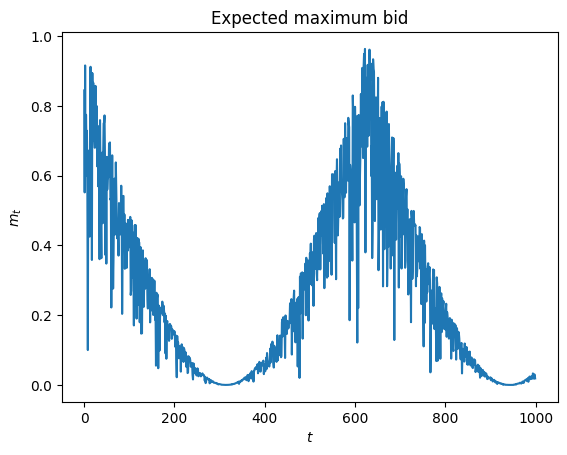

In [12]:
### Adversarial Bidders

n_advertisers = 3
n_users = 1000
B = 50

# non-trivial scenario: competitors sample bids from a uniform with range varying over time
pattern = lambda t: 1-np.abs(np.sin(5*t/n_users))
other_bids = np.array([np.random.uniform(0, pattern(t), size = n_advertisers) for t in range(n_users)]).T
# I assume that competitors may have a larger budget than mine, but they may
# not deplete it.

m_t = other_bids.max(axis=0)

plt.plot(m_t)
plt.title('Expected maximum bid')
plt.xlabel('$t$')
plt.ylabel('$m_t$')
plt.show()

#### Adversarial baseline:
$$ maximize~~~ \sum_b \gamma(b)(v - b)\bar{\mathbb{P}}_m(b \ge m) ~~~ s.t. \sum_b b \gamma(b) \bar{\mathbb{P}}_m(b \ge m) \le \rho,$$
#### where $\gamma(b)$ is the probability of bidding $b$ and $\bar{\mathbb{P}}_m(b \ge m)$ is the empirical win probability over all rounds. This is a Linear Program! (LP)

In [13]:
available_bids = np.linspace(0,1,11)
win_probabilities = np.array([sum(b > m_t)/n_users for b in available_bids])

In [14]:
## Linear Program
c = -(my_valuation-available_bids)*win_probabilities
A_ub = [available_bids*win_probabilities]
b_ub = [rho]
A_eq = [np.ones(len(available_bids))]
b_eq = [1]
res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(0,1))
gamma = res.x
expected_clairvoyant_utilities = [-res.fun for u in range(n_users)]
expected_clairvoyant_bids = [sum(available_bids*gamma*win_probabilities) for u in range(n_users)]

## UCB-like approach for stochastic setting

### Compute UCBs $f^{\text{UCB}}(b)$ and LCBs $c^{\text{LCB}}(b)$ for every $b \in B$
### Solve the optimization problem:
$$ \text{maximize}_{\gamma \in \Delta(B)}~~~ \sum_b \gamma(b) f^{\text{UCB}}(b) ~~~ \text{s.t.} \sum_b \gamma(b) c^{\text{LCB}}(b) \le \rho,$$
### Update with bandit feedback

In [15]:
# the agent does not need the values of the available bids or the valuation
# the first bid is 0
class UCBLikeAgent():
    def __init__(self, K, B, T, range=1):
        self.K = K
        self.T = T
        self.range = range
        self.a_t = None # it's an index, not the actual bid
        self.avg_f = np.zeros(K)
        self.avg_c = np.zeros(K)
        self.N_pulls = np.zeros(K)
        self.budget = B
        self.rho = B/T
        self.t = 0
    
    def pull_arm(self):
        if self.budget < 1:
            self.a_t = 0
            return 0
        if self.t < self.K:
            self.a_t = self.t 
        else:
            f_ucbs = self.avg_f + self.range*np.sqrt(2*np.log(self.T)/self.N_pulls)
            c_lcbs = self.avg_c - self.range*np.sqrt(2*np.log(self.T)/self.N_pulls)
            gamma_t = self.compute_opt(f_ucbs, c_lcbs)
            self.a_t = np.random.choice(self.K, p=gamma_t)
        return self.a_t

    def compute_opt(self, f_ucbs, c_lcbs):
        if np.sum(c_lcbs <= np.zeros(len(c_lcbs))):
            gamma = np.zeros(len(f_ucbs))
            gamma[np.argmax(f_ucbs)] = 1
            return gamma
        c = -f_ucbs
        A_ub = [c_lcbs]
        b_ub = [self.rho]
        A_eq = [np.ones(self.K)]
        b_eq = [1]
        res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(0,1))
        gamma = res.x
        return gamma
    
    def update(self, f_t, c_t):
        self.N_pulls[self.a_t] += 1
        self.avg_f[self.a_t] += (f_t - self.avg_f[self.a_t])/self.N_pulls[self.a_t]
        self.avg_c[self.a_t] += (c_t - self.avg_c[self.a_t])/self.N_pulls[self.a_t]
        self.budget -= c_t
        self.t += 1

### Setting

In [16]:
### Stochastic Bidders: my competitors sample their bids from 
### probability distributions

n_advertisers = 3
n_users = 5000
B = 300
my_valuation = 0.6
rho = B/n_users

### competitor sample from uniform in [0,1]
available_bids = np.linspace(0,1,11)
# available_bids = np.linspace(0,my_valuation,11)
win_probabilities = stats.beta.cdf(available_bids, n_advertisers, 1)

gamma, expected_clairvoyant_utility, expected_clairvoyant_payment = compute_clairvoyant(available_bids, my_valuation, rho, win_probabilities)
# per round values

print(gamma)

[ 0.  0.  0.  0.  1. -0.  0.  0.  0.  0.  0.]


In [17]:
good_bids = available_bids[available_bids<=my_valuation] # you can remove bids greater than the valuation
# good_bids = available_bids 
agent = UCBLikeAgent(K=len(good_bids), 
                     B=B,
                     T=n_users,
                     range=my_valuation)

auction = FirstPriceAuction(np.ones(n_advertisers+1))

utilities = []
my_bids = []
my_payments = []
total_wins = 0

np.random.seed(17)
other_bids = np.random.uniform(0, 1, size = (n_advertisers, n_users))
m_t = other_bids.max(axis=0)
for u in range(n_users):
    # interaction
    my_bid = available_bids[agent.pull_arm()]
    bids = np.append(my_bid, other_bids[:, u].ravel())
    winners, payments_per_click = auction.round(bids=bids)
    my_win = int(winners==0)
    f_t, c_t = (my_valuation-payments_per_click)*my_win, payments_per_click*my_win
    agent.update(f_t, c_t)
    # logging
    utilities.append(f_t)
    my_bids.append(my_bid)
    my_payments.append(c_t)
    total_wins+=my_win

utilities = np.array(utilities)
my_bids = np.array(my_bids)
my_payments = np.array(my_payments)
print(f'Total # of Wins: {total_wins}')

Total # of Wins: 198


<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\s'
C:\Users\matteo\AppData\Local\Temp\ipykernel_3244\2627635398.py:4: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sum c_t$')


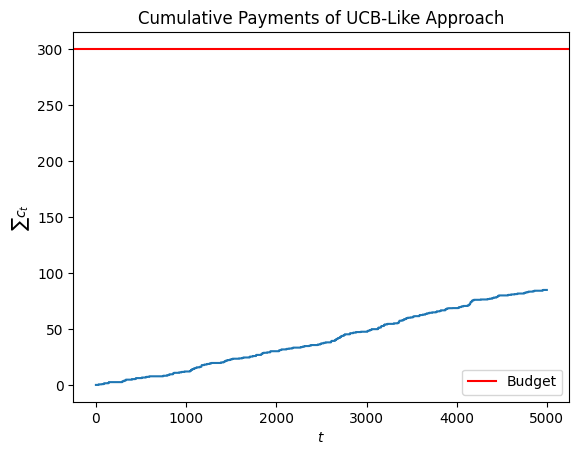

In [19]:
cumulative_payments = np.cumsum(my_payments)
plt.plot(cumulative_payments)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(B, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments of UCB-Like Approach')
plt.show()

<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\s'
C:\Users\matteo\AppData\Local\Temp\ipykernel_3244\2983216223.py:4: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sum R_t$')


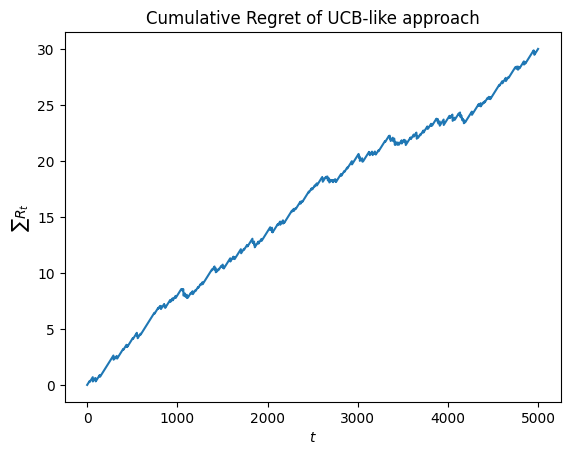

In [20]:
cumulative_regret = np.cumsum(expected_clairvoyant_utility-utilities)
plt.plot(cumulative_regret)
plt.xlabel('$t$')
plt.ylabel('$\sum R_t$')
plt.title('Cumulative Regret of UCB-like approach')
plt.show()

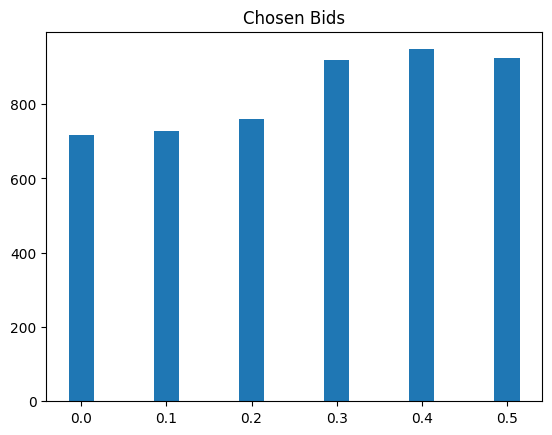

In [21]:
plt.bar(good_bids, agent.N_pulls, width=0.03)
plt.title('Chosen Bids')
plt.show()

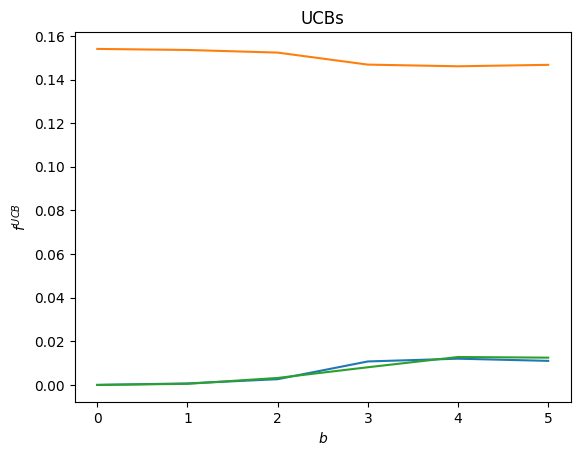

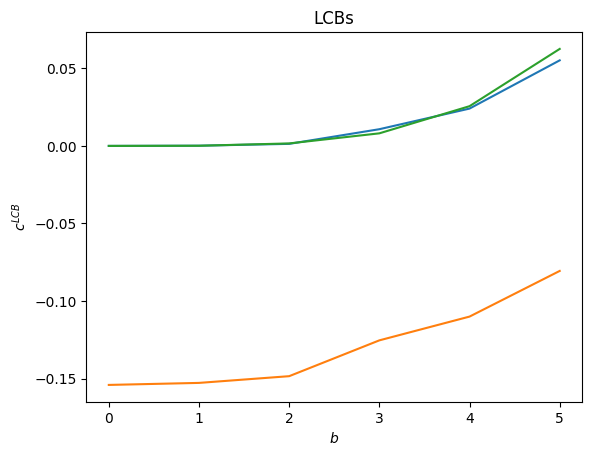

[0.    0.001 0.008 0.027 0.064 0.125 0.216 0.343 0.512 0.729 1.   ]
[718. 729. 760. 920. 948. 925.]
0.05836846131744861


In [22]:
f_ucbs = agent.avg_f + np.sqrt(2*np.log(agent.T)/agent.N_pulls)
c_lcbs = agent.avg_c - np.sqrt(2*np.log(agent.T)/agent.N_pulls)
plt.plot(agent.avg_f, label='est f')
plt.plot(f_ucbs, label='UCB')
plt.plot(win_probabilities[:len(f_ucbs)]*(my_valuation-available_bids[:len(f_ucbs)]), label='est f')
plt.xlabel('$b$')
plt.ylabel('$f^{UCB}$')
plt.title('UCBs')
plt.show()

plt.plot(agent.avg_c)
plt.plot(c_lcbs)
plt.plot(win_probabilities[:len(f_ucbs)]*available_bids[:len(f_ucbs)], label='est f')
plt.xlabel('$b$')
plt.ylabel('$c^{LCB}$')
plt.title('LCBs')
plt.show()

print(win_probabilities)
print(agent.N_pulls)
print(np.sqrt(2*np.log(n_users)/n_users))

### It needs way more samples to get meaningful bounds.
### Run it with larger budget and number of users (constant $\rho$)

### **Remark**: for a proper estimation you need to run multiple trials and compute average and std.

## Generalized Multiplicative Pacing for Non-Truthful Auctions

#### Here, we will assume a **full-feedback** setting. In auctions, full-feedback is equivalent of knowing the maximum bid $m_t$ that won the auction (of course, **after** the auction). Moreover, bids will be **discretized** into a finite set of actions.

#### We will leverage a full-feedback, adversarial learner such as Hedge (see Lab 2).

In [23]:
class HedgeAgent:
    def __init__(self, K, learning_rate):
        self.K = K
        self.learning_rate = learning_rate
        self.weights = np.ones(K)
        self.x_t = np.ones(K)/K
        self.a_t = None
        self.t = 0

    def pull_arm(self):
        self.x_t = self.weights/sum(self.weights)
        self.a_t = np.random.choice(np.arange(self.K), p=self.x_t)
        return self.a_t
    
    def update(self, l_t):
        self.weights *= np.exp(-self.learning_rate*l_t)
        self.t += 1

In [24]:
class FFMultiplicativePacingAgent:
    def __init__(self, bids_set, valuation, budget, T, eta):
        self.bids_set = bids_set
        self.K = len(bids_set)
        self.hedge = HedgeAgent(self.K, np.sqrt(np.log(self.K)/T))
        self.valuation = valuation
        self.budget = budget
        self.eta = eta
        self.T = T
        self.rho = self.budget/self.T
        self.lmbd = 1
        self.t = 0
        self.N_pulls = np.zeros(len(bids_set))
        self.bid_index = 0

    def bid(self):
        if self.budget < 1:
            self.bid_index = 0
            return 0
        self.bid_index = self.hedge.pull_arm()
        return self.bids_set[self.bid_index]
    
    def update(self, f_t, c_t, m_t):
        # update hedge
        f_t_full = np.array([(self.valuation-b)*int(b >= m_t) for b in self.bids_set])
        c_t_full = np.array([b*int(b >= m_t) for b in self.bids_set])
        L = f_t_full - self.lmbd*(c_t_full-self.rho)
        
        L_up = 1 -(1/self.rho)*(-self.rho)
        L_low = 0 -(1/self.rho)*(1-self.rho)
        rescaled_L = (L - L_low)/(L_up-L_low)
        self.hedge.update(1 -rescaled_L) # we need to maximize L

        # update lagrangian multiplier
        self.lmbd = np.clip(self.lmbd-self.eta*(self.rho-c_t), 
                            a_min=0, a_max=1/self.rho)
        # update budget
        self.budget -= c_t
        # log
        self.N_pulls[self.bid_index] += 1

#### Let's try it in a stochastic environment

#### Setting:

In [25]:
### Stochastic Bidders: my competitors sample their bids from 
### probability distributions

n_advertisers = 3
n_users = 5000
B = 300
my_valuation = 0.6
rho = B/n_users

### competitor sample from uniform in [0,1]
available_bids = np.linspace(0,1,11)
# available_bids = np.linspace(0,my_valuation,11)
win_probabilities = stats.beta.cdf(available_bids, n_advertisers, 1)

gamma_clairvoyant, expected_clairvoyant_utility, expected_clairvoyant_payment = compute_clairvoyant(available_bids, my_valuation, rho, win_probabilities)
# per round values

print(gamma_clairvoyant)

[ 0.  0.  0.  0.  1. -0.  0.  0.  0.  0.  0.]


#### Trial:

In [26]:
eta = 1/np.sqrt(n_users) # from theory
agent = FFMultiplicativePacingAgent(bids_set = available_bids, 
                                    valuation=my_valuation,
                                    budget=B,
                                    T=n_users, 
                                    eta=eta)

auction = FirstPriceAuction(np.ones(n_advertisers+1))

utilities = np.array([])
my_bids = np.array([])
my_payments = np.array([])
total_wins = 0

np.random.seed(17)
other_bids = np.random.uniform(0, 1, size = (n_advertisers, n_users))
m_t = other_bids.max(axis=0)
for u in range(n_users):
    # interaction
    my_bid = agent.bid()
    bids = np.append(my_bid, other_bids[:, u].ravel())
    winners, payments_per_click = auction.round(bids=bids)
    my_win = int(winners==0)
    f_t, c_t = (my_valuation-payments_per_click)*my_win, payments_per_click*my_win
    agent.update(f_t, c_t, m_t[u])
    # logging
    utilities = np.append(utilities, f_t)
    my_bids = np.append(my_bids, my_bid)
    my_payments = np.append(my_payments, c_t)
    total_wins+=my_win
print(f'Total # of Wins: {total_wins}')

Total # of Wins: 407


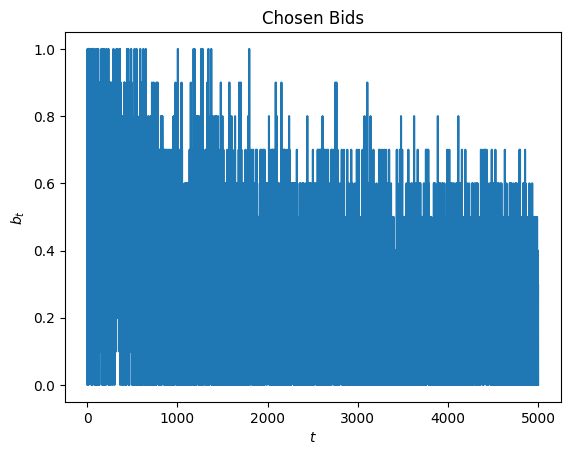

C:\Users\matteo\AppData\Local\Temp\ipykernel_3244\1204424048.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


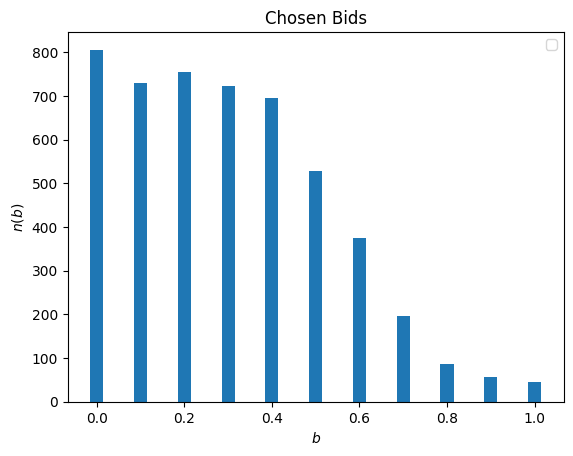

In [27]:
plt.plot(my_bids)
plt.xlabel('$t$')
plt.ylabel('$b_t$')
plt.title('Chosen Bids')
plt.show()

plt.title("Chosen Bids")
width = 0.03
plt.bar(available_bids, agent.N_pulls, width=width, align='center')
plt.xlabel('$b$')
plt.ylabel('$n(b)$')
plt.legend()
plt.show()

<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\s'
C:\Users\matteo\AppData\Local\Temp\ipykernel_3244\4024054808.py:4: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sum c_t$')


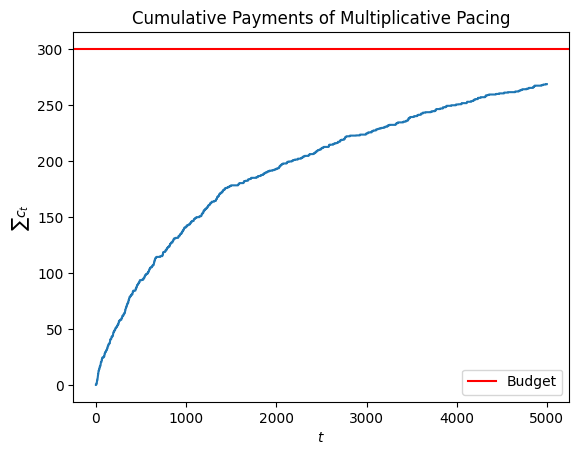

In [28]:
cumulative_payments = np.cumsum(my_payments)
plt.plot(cumulative_payments)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(B, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments of Multiplicative Pacing')
plt.show()

<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\s'
C:\Users\matteo\AppData\Local\Temp\ipykernel_3244\1245228247.py:4: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sum R_t$')


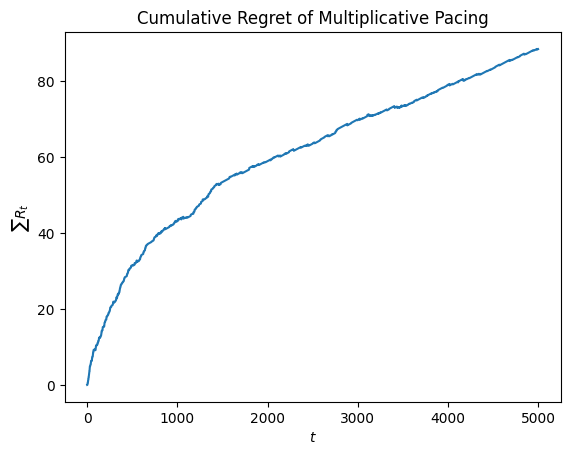

In [29]:
cumulative_regret = np.cumsum(expected_clairvoyant_utility-utilities)
plt.plot(cumulative_regret)
plt.xlabel('$t$')
plt.ylabel('$\sum R_t$')
plt.title('Cumulative Regret of Multiplicative Pacing')
plt.show()

#### We need multiple trials for a proper estimation

In [30]:
# n_epochs = 50
n_epochs = 5
all_regrets = []
all_payments = []
all_pulls = []
for i in range(n_epochs):
    agent = FFMultiplicativePacingAgent(bids_set = available_bids, 
                                        valuation=my_valuation,
                                        budget=B,
                                        T=n_users, 
                                        eta=eta)

    auction = FirstPriceAuction(np.ones(n_advertisers+1))
    utilities = np.array([])
    my_bids = np.array([])
    my_payments = np.array([])

    np.random.seed(i)
    other_bids = np.random.uniform(0, 1, size = (n_advertisers, n_users))
    m_t = other_bids.max(axis=0)
    for u in range(n_users):
        # interaction
        my_bid = agent.bid()
        bids = np.append(my_bid, other_bids[:, u].ravel())
        winners, payments_per_click = auction.round(bids=bids)
        my_win = int(winners==0)
        f_t, c_t = (my_valuation-payments_per_click)*my_win, payments_per_click*my_win
        agent.update(f_t, c_t, m_t[u])
        # logging
        utilities = np.append(utilities, f_t)
        my_payments = np.append(my_payments, c_t)
    all_regrets.append(np.cumsum(expected_clairvoyant_utility-utilities))
    all_payments.append(np.cumsum(my_payments))
    all_pulls.append(agent.N_pulls)

avg_regret = np.array(all_regrets).mean(axis=0)
std_regret = np.array(all_regrets).std(axis=0)

avg_payments = np.array(all_payments).mean(axis=0)
std_payments = np.array(all_payments).std(axis=0)

avg_pulls = np.array(all_pulls).mean(axis=0)
std_pulls = np.array(all_pulls).std(axis=0)

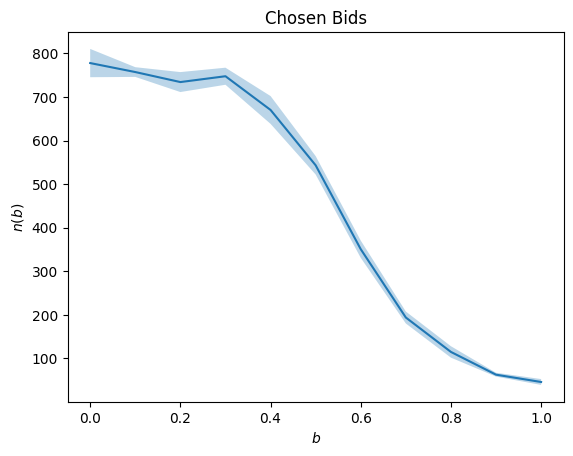

In [31]:
plt.plot(available_bids, avg_pulls)
plt.fill_between(available_bids, avg_pulls-std_pulls, avg_pulls+std_pulls, alpha=0.3)
plt.plot()
plt.xlabel('$b$')
plt.ylabel('$n(b)$')
plt.title('Chosen Bids')
plt.show()

<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\s'
C:\Users\matteo\AppData\Local\Temp\ipykernel_3244\1117506322.py:4: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sum c_t$')


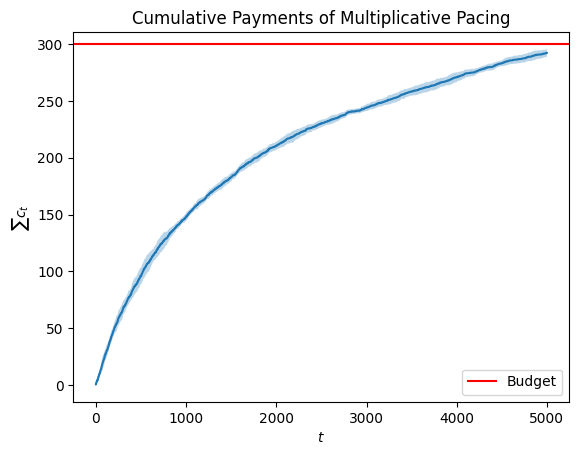

In [32]:
plt.plot(np.arange(n_users), avg_payments)
plt.fill_between(np.arange(n_users), avg_payments-std_payments, avg_payments+std_payments, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(B, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments of Multiplicative Pacing')
plt.show()

<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\s'
C:\Users\matteo\AppData\Local\Temp\ipykernel_3244\2596992327.py:4: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sum R_t$')


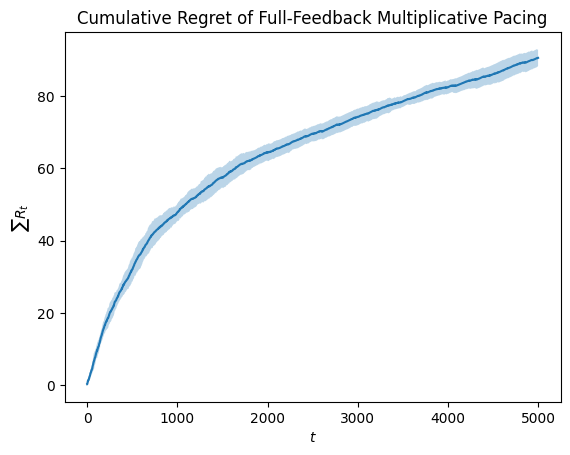

In [33]:
plt.plot(np.arange(n_users), avg_regret)
plt.fill_between(np.arange(n_users), avg_regret-std_regret, avg_regret+std_regret, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum R_t$')
plt.title('Cumulative Regret of Full-Feedback Multiplicative Pacing')
plt.show()